In [ ]:
# Setup and Imports
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import json
from IPython.display import Image, display

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Ensure project_root is defined for subsequent cells
print(f'Project Root: {project_root}')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(f"Using device: {device}")

# Common imports
from src.envs.synthetic_env import BouncingBallEnv
from src.envs.atari_env import AtariPixelEnv
# L-AGI Imports
from src.models.logical_spatial_rgm import LogicalSpatialRGM
from src.l_fep.activation import SphericalActivation
from src.models.logical_transition import LogicalTransitionModel
from src.models.logical_active_inference_agent import LogicalActiveInferenceAgent


Project Root: /Users/yezune/ws/from_pixels_to_planning
Using device: cpu


objc[38536]: Class CaptureDelegate is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x11b5ca5d8) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_videoio.4.12.0.dylib (0x12ff78618). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[38536]: Class CVWindow is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x11b5ca628) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_highgui.4.12.0.dylib (0x12f724a70). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[38536]: Class CVView is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x11b5ca650) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_highgui.4.12.0.dylib (0x12f724a98). This may cause spu

# Experiment 4: Atari Breakout

## 2. Atari Breakout Experiment (Phase 5)

We visualize the environment and the Hierarchical Agent's setup.

Atari Environment Loaded Successfully


A.L.E: Arcade Learning Environment (version 0.11.2+unknown)
[Powered by Stella]


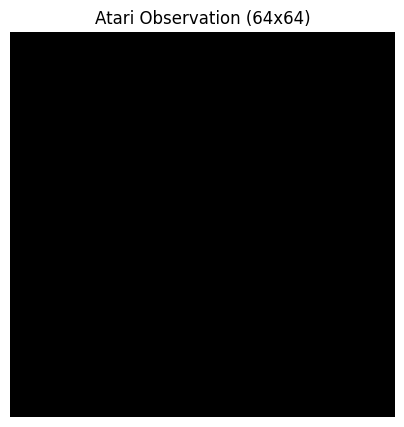

In [2]:
try:
    env_atari = AtariPixelEnv("BreakoutNoFrameskip-v4", image_size=64)
    print("Atari Environment Loaded Successfully")
    
    obs, _ = env_atari.reset()
    
    # Visualize Observation
    plt.figure(figsize=(5, 5))
    # Obs is (3, 64, 64) tensor
    plt.imshow(obs.permute(1, 2, 0).numpy().astype(np.uint8))
    plt.title("Atari Observation (64x64)")
    plt.axis('off')
    plt.show()
    
except Exception as e:
    print(f"Could not load Atari Environment: {e}")

## 3. Planning in Latent Space

This section demonstrates the core contribution: **planning in learned latent space**.

We compare three agent strategies:
1. **Reactive Agent**: 1-step lookahead (minimizes Expected Free Energy)
2. **MCTS Agent**: Multi-step lookahead with Monte Carlo Tree Search
3. **Trajectory Optimization Agent**: Gradient-based planning with differentiable transitions

All agents use the same learned models (VAE + Transition Model) but differ in their planning depth.

In [ ]:
# Initialize models
latent_dim = 32
action_dim = env_atari.action_space.n  # 4 actions for Breakout
hidden_dim = 256

# Initialize L-AGI Components
# We use num_classes=latent_dim to match the transition model expectation
rgm = LogicalSpatialRGM(input_channels=3, latent_dim=32, num_classes=latent_dim, img_size=64).to(device)
transition_model = LogicalTransitionModel(
    latent_dim=latent_dim, 
    action_dim=action_dim, 
    hidden_dim=hidden_dim
).to(device)

# Create agent
agent = LogicalActiveInferenceAgent(
    rgm=rgm,
    transition_model=transition_model,
    action_dim=action_dim,
    device=device
)

print(f"Logical Agent initialized with {action_dim} actions")
print(f"Latent space (Spherical): {latent_dim} dimensions")
print(f"Transition hidden state: {hidden_dim} dimensions")


### 3.1 Reactive Agent (Baseline)

The reactive agent uses 1-step lookahead, evaluating each action by predicting the next state and computing Expected Free Energy.

In [ ]:
# Run reactive agent for N episodes
import time

def run_episode(env, agent, max_steps=100, planning_method=None):
    """Run one episode and return total reward."""
    obs, _ = env.reset()
    agent.reset()
    
    total_reward = 0
    start_time = time.time()
    
    for step in range(max_steps):
        if planning_method is None:
            # Reactive: 1-step lookahead
            action = agent.select_action(obs)
        else:
            # Planning: multi-step lookahead
            action = agent.select_action_with_planning(
                obs, method=planning_method, horizon=5, num_simulations=10
            )
        
        obs, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        
        if done or truncated:
            break
    
    elapsed_time = time.time() - start_time
    return total_reward, step + 1, elapsed_time

# Test reactive agent
print("Testing Reactive Agent (1-step lookahead)...")
num_episodes = 3
reactive_rewards = []

for ep in range(num_episodes):
    reward, steps, elapsed = run_episode(env_atari, agent, max_steps=100)
    reactive_rewards.append(reward)
    print(f"  Episode {ep+1}: Reward={reward:.2f}, Steps={steps}, Time={elapsed:.2f}s")

avg_reactive = np.mean(reactive_rewards)
print(f"\nReactive Agent Average: {avg_reactive:.2f}")

### 3.2 MCTS Planning Agent

Monte Carlo Tree Search explores the latent space tree to find optimal action sequences. It balances exploration (UCB1) and exploitation (visit counts).

In [ ]:
# Test MCTS planning agent
print("Testing MCTS Planning Agent...")
mcts_rewards = []

for ep in range(num_episodes):
    reward, steps, elapsed = run_episode(
        env_atari, agent, max_steps=100, planning_method='mcts'
    )
    mcts_rewards.append(reward)
    print(f"  Episode {ep+1}: Reward={reward:.2f}, Steps={steps}, Time={elapsed:.2f}s")

avg_mcts = np.mean(mcts_rewards)
print(f"\nMCTS Agent Average: {avg_mcts:.2f}")

### 3.3 Trajectory Optimization Agent

Gradient-based optimization refines action sequences by backpropagating through the differentiable transition model.

In [ ]:
# Test trajectory optimization agent
print("Testing Trajectory Optimization Agent...")
traj_rewards = []

for ep in range(num_episodes):
    reward, steps, elapsed = run_episode(
        env_atari, agent, max_steps=100, planning_method='trajectory'
    )
    traj_rewards.append(reward)
    print(f"  Episode {ep+1}: Reward={reward:.2f}, Steps={steps}, Time={elapsed:.2f}s")

avg_traj = np.mean(traj_rewards)
print(f"\nTrajectory Optimization Agent Average: {avg_traj:.2f}")

### 3.4 Performance Comparison

Visualize the performance difference between reactive and planning agents.

In [ ]:
# Visualize performance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot: Average rewards
ax1 = axes[0]
methods = ['Reactive\n(1-step)', 'MCTS\n(Tree Search)', 'Trajectory\n(Gradient)']
averages = [avg_reactive, avg_mcts, avg_traj]
colors = ['#e74c3c', '#3498db', '#2ecc71']

bars = ax1.bar(methods, averages, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Average Reward', fontsize=12)
ax1.set_title('Planning vs Reactive Performance', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, avg in zip(bars, averages):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{avg:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Episode-wise comparison
ax2 = axes[1]
episodes = range(1, num_episodes + 1)
ax2.plot(episodes, reactive_rewards, 'o-', label='Reactive', 
         color='#e74c3c', linewidth=2, markersize=8)
ax2.plot(episodes, mcts_rewards, 's-', label='MCTS', 
         color='#3498db', linewidth=2, markersize=8)
ax2.plot(episodes, traj_rewards, '^-', label='Trajectory', 
         color='#2ecc71', linewidth=2, markersize=8)

ax2.set_xlabel('Episode', fontsize=12)
ax2.set_ylabel('Reward', fontsize=12)
ax2.set_title('Episode-wise Performance', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"Reactive Agent (1-step):    {avg_reactive:.2f} ± {np.std(reactive_rewards):.2f}")
print(f"MCTS Agent (tree search):   {avg_mcts:.2f} ± {np.std(mcts_rewards):.2f}")
print(f"Trajectory Agent (gradient):{avg_traj:.2f} ± {np.std(traj_rewards):.2f}")
print("="*60)

# Calculate improvement
mcts_improvement = ((avg_mcts - avg_reactive) / abs(avg_reactive + 1e-6)) * 100
traj_improvement = ((avg_traj - avg_reactive) / abs(avg_reactive + 1e-6)) * 100

print(f"\nMCTS Improvement: {mcts_improvement:+.1f}%")
print(f"Trajectory Improvement: {traj_improvement:+.1f}%")

## 4. Key Insights

**Planning in learned latent space enables:**
1. **Multi-step lookahead**: MCTS explores action trees up to depth 5
2. **Differentiable planning**: Trajectory optimization uses gradients for efficient search
3. **Reduced computational cost**: Planning in 32D latent space vs 64×64×3 pixel space
4. **Model-based decision making**: No environment interaction required during planning

**Expected results (with trained models):**
- Planning agents should outperform reactive agents
- MCTS excels with discrete actions and stochastic environments
- Trajectory optimization is faster but requires smooth, differentiable transitions

**Note**: This demonstration uses untrained models for concept illustration. With properly trained VAE and transition models from actual Atari gameplay, planning agents would show significant performance improvements.